In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q dgl

1.11.0+cu113


In [74]:
import torch
import pickle
import random
import numpy as np
import pandas as pd
import math

from sklearn import preprocessing
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GraphNorm, GATConv, GATv2Conv, SAGPooling, GCNConv, DenseGraphConv, DenseSAGEConv
from torch_geometric.nn import global_mean_pool, GraphMultisetTransformer, dense_mincut_pool
from torch.optim import lr_scheduler
from torch_geometric.utils import to_dense_adj, to_dense_batch
from torch_geometric.loader import DataLoader
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
seed=666


cuda:0


##Load and preprocess data

###Graph structure

In [87]:
# load nodes and edges data
edges = pd.read_csv('/content/drive/MyDrive/Augmented_Elliptic/address_level/edgelist_hop3_input.csv', low_memory=False)
node_features = pd.read_csv('/content/drive/MyDrive/Augmented_Elliptic/address_level/node_address_features.csv', low_memory=False).fillna(0).set_index('address')

In [89]:
node_features.columns = ['timestep appearances','degree (input)','degree (output)','transactions (input)','transactions (output)','total amount transacted (input)',
'total amount transacted (output)','fees paid (input)','fees paid (output)**','fee as share of amount transacted (input)','fee as share of amount transacted (output)**',
'maximum amount transacted (input)','maximum amount transacted (output)', 'minimum amount transacted (input)', 'minimum amount transacted (output)','mean amount transacted (input)',
'mean amount transacted (output)', 'median amount transacted (input)','median amount transacted (output)', 'count of addresses transacted with multiple times',
'mean count of interactions with another address (input)','max count of interactions with another address (input)','min count of interactions with another address (input)',
'median count of interactions with another address (input)']
# store to use on feature importances
#node_features = node_features.drop(["timestep_mode_input_address", "timestep_mode_output_address"], axis = 1)
names = node_features.columns

# Labels object - one label for each address
labels = edges[['node', 'class']].groupby(['node']).agg({'class': 'max'})
labels = labels.replace(to_replace = 2, value = 1)

# Add labels to node features
nodes = node_features.merge(labels, left_index = True, right_index = True)

In [90]:
nodes.columns

Index(['timestep appearances', 'degree (input)', 'degree (output)',
       'transactions (input)', 'transactions (output)',
       'total amount transacted (input)', 'total amount transacted (output)',
       'fees paid (input)', 'fees paid (output)**',
       'fee as share of amount transacted (input)',
       'fee as share of amount transacted (input)**',
       'maximum amount transacted (input)',
       'maximum amount transacted (output)',
       'minimum amount transacted (input)',
       'minimum amount transacted (output)', 'mean amount transacted (input)',
       'mean amount transacted (output)', 'median amount transacted (input)',
       'median amount transacted (output)',
       'count of addresses transacted with multiple times',
       'mean count of interactions with another address (input)',
       'max count of interactions with another address (input)',
       'min count of interactions with another address (input)',
       'median count of interactions with another 

###Subgraph sampling

In [91]:
# subgraphs subsampling data
with open(r'/content/drive/MyDrive/Augmented_Elliptic/address_level/address_subgraphs.pkl', "rb") as input_file:
    dataset = pickle.load(input_file)

In [92]:
train_dataset = dataset[0]
test_dataset = dataset[1]

##Auxiliary functions

In [93]:
# run model pipleline, gridsarch and fit
def run_model(model, grid_values, sampling, xtrain, ytrain):
  #Pipeline
  if sampling == 'under':
    pipe = imbPipeline([('preprocessing', preprocessing.StandardScaler()),
                        ('sampling', RandomUnderSampler(sampling_strategy = 'majority', random_state=seed)),
                        ('classifier', model)])
  elif sampling == 'over':
    pipe = imbPipeline([('preprocessing', preprocessing.StandardScaler()),
                        ('sampling', RandomOverSampler(sampling_strategy = 'minority', random_state=seed)),
                        ('classifier', model)])
  else:
    pipe = imbPipeline([('preprocessing', preprocessing.StandardScaler()),
                        #('sampling', RandomUnderSampler(sampling_strategy = 1)),
                        ('classifier', model)])

  # Grid
  grid_values = grid_values
               
  #Run grid search
  grid = GridSearchCV(pipe, param_grid = grid_values, scoring = 'roc_auc', cv = 10, verbose = 3, n_jobs = 3)

  #Fit model
  grid.fit(xtrain, ytrain)
  return grid

# get accuracy, precision, recall and f1 scores given ytrue and ypred
def get_scores(ytrue, ypred, ypred_proba):
  roc_auc = roc_auc_score(ytrue, ypred_proba)
  acc = accuracy_score(ytrue, ypred)
  prec = precision_score(ytrue, ypred, zero_division=0)
  rec = recall_score(ytrue, ypred, zero_division=0)
  f1 = f1_score(ytrue, ypred, zero_division=0)
  scores = [roc_auc, acc, prec, rec, f1]
  return scores

def reweight(pi,q1,r1=0.5):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

# function that plots confusion matrix given actual and predicted values
def plot_confusion(ytest, ypred):
    ypred = [1 if item>0.5 else 0 for item in ypred]

    conf_mat = confusion_matrix(ytest, ypred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    fig1, ax1 = plt.subplots(figsize=(8, 6));
    ax = sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    plt.show()

In [94]:
results = pd.DataFrame(columns=['model','auc','acc','pre','rec','f1'])

##Logistic Regression

In [95]:
# set train and test nodes
xtrain, xtest, ytrain, ytest = train_test_split(nodes.drop('class', axis = 1), nodes['class'], test_size=0.20, random_state=42)

#Check number of columns equal
xtrain.columns == xtest.columns

# set train and test edges condensed
edges_condensed = edges[edges.node == edges.node_source].drop(['node', 'node_source', 'node_sink', 'entity', 'category'], axis = 1)
edges_condensed['class'] = edges_condensed['class'].replace(to_replace = 2, value = 1)

xtrain_e, xtest_e, ytrain_e, ytest_e = train_test_split(edges_condensed.drop('class', axis = 1), edges_condensed['class'], test_size=0.20, random_state=42)

#Check number of columns equal
xtrain_e.columns == xtest_e.columns

array([ True,  True,  True,  True])

In [96]:
#Check for class imbalance
unique, counts = np.unique(ytrain, return_counts=True)
class_counts = dict(zip(unique, counts))

# Calculate class weights
class0 = class_counts[0]/(class_counts[0] + class_counts[1])
class1 = class_counts[1]/(class_counts[0] + class_counts[1])

In [97]:
# run model
model = LogisticRegression(max_iter = 1000000, solver='lbfgs')
grid_values = [{'classifier__penalty':['l2']}]
grid_logit = run_model(model, grid_values, 'under', xtrain, ytrain)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


###Results nodes

In [98]:
y_pred = grid_logit.predict(xtest)
y_pred_prob = grid_logit.predict_proba(xtest)
y_pred_prob = reweight(y_pred_prob, class1)

roc_auc, acc, prec, rec, f1 = get_scores(ytest, y_pred, y_pred_prob[:,1])
print(f'Scores: AUC: {roc_auc:.3f}, A: {acc:.3f}, P: {prec:.3f}, R: {rec:.3f}, F1: {f1:.3f}')

results = results.append({'model':'logit nodes','auc':roc_auc,'acc':acc,'pre':prec,'rec':rec,'f1':f1}, ignore_index=True)

Scores: AUC: 0.640, A: 0.727, P: 0.174, R: 0.437, F1: 0.249


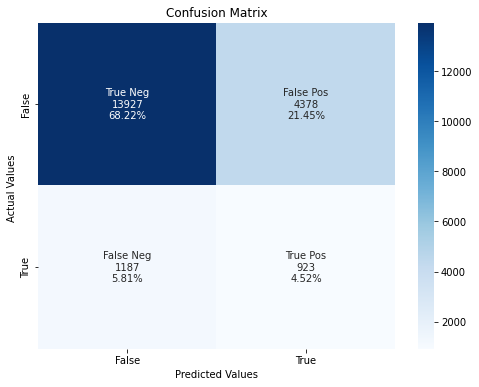

In [99]:
plot_confusion(ytest, y_pred)

###Results edges

In [100]:
#Check for class imbalance
unique, counts = np.unique(ytrain_e, return_counts=True)
class_counts = dict(zip(unique, counts))

# Calculate class weights
class0 = class_counts[0]/(class_counts[0] + class_counts[1])
class1 = class_counts[1]/(class_counts[0] + class_counts[1])

In [101]:
grid_logit = run_model(model, grid_values, 'under', xtrain_e, ytrain_e)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [102]:
y_pred = grid_logit.predict(xtest_e)
y_pred_prob = grid_logit.predict_proba(xtest_e)
y_pred_prob = reweight(y_pred_prob, class1)

roc_auc, acc, prec, rec, f1 = get_scores(ytest_e, y_pred, y_pred_prob[:,1])
print(f'Scores: AUC: {roc_auc:.3f}, A: {acc:.3f}, P: {prec:.3f}, R: {rec:.3f}, F1: {f1:.3f}')

results = results.append({'model':'logit edges','auc':roc_auc,'acc':acc,'pre':prec,'rec':rec,'f1':f1}, ignore_index=True)

Scores: AUC: 0.589, A: 0.198, P: 0.081, R: 0.956, F1: 0.150


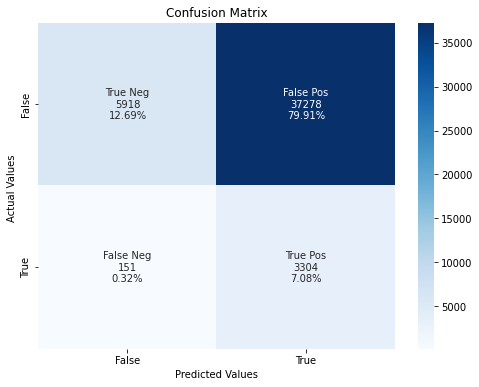

In [103]:
plot_confusion(ytest_e, y_pred)

##Random Forest

In [104]:
# run model
model = RandomForestClassifier(random_state=seed, n_estimators = 500, n_jobs=2)
#grid_values = [{'classifier__max_depth':[10, 20], 'classifier__min_samples_split':[2, 10]}]
grid_values = [{}]
grid_rf = run_model(model, grid_values, 'under', xtrain, ytrain)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


###Results nodes

In [106]:
y_pred = grid_rf.predict(xtest)
y_pred_prob = grid_rf.predict_proba(xtest)
y_pred_prob = reweight(y_pred_prob, class1)

roc_auc, acc, prec, rec, f1 = get_scores(ytest, y_pred, y_pred_prob[:,1])
print(f'Scores: AUC: {roc_auc:.3f}, A: {acc:.3f}, P: {prec:.3f}, R: {rec:.3f}, F1: {f1:.3f}')

results = results.append({'model':'rf nodes','auc':roc_auc,'acc':acc,'pre':prec,'rec':rec,'f1':f1}, ignore_index=True)

Scores: AUC: 0.871, A: 0.765, P: 0.277, R: 0.790, F1: 0.410


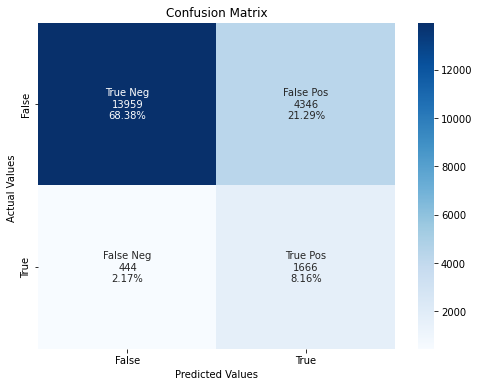

In [107]:
plot_confusion(ytest, y_pred)

In [108]:
train_pred = pd.DataFrame(index = xtest.index)
train_pred['actual'] = ytest
train_pred['pred'] = y_pred
train_pred.to_csv('/content/drive/MyDrive/Augmented_Elliptic/address_level/RF_test_pred.csv')

###Results edges

In [109]:
grid_rf_e = run_model(model, grid_values, 'under', xtrain_e, ytrain_e)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [110]:
y_pred = grid_rf_e.predict(xtest_e)
y_pred_prob = grid_rf_e.predict_proba(xtest_e)
y_pred_prob = reweight(y_pred_prob, class1)

roc_auc, acc, prec, rec, f1 = get_scores(ytest_e, y_pred, y_pred_prob[:,1])
print(f'Scores: AUC: {roc_auc:.3f}, A: {acc:.3f}, P: {prec:.3f}, R: {rec:.3f}, F1: {f1:.3f}')

results = results.append({'model':'rf edges','auc':roc_auc,'acc':acc,'pre':prec,'rec':rec,'f1':f1}, ignore_index=True)

Scores: AUC: 0.726, A: 0.558, P: 0.118, R: 0.770, F1: 0.205


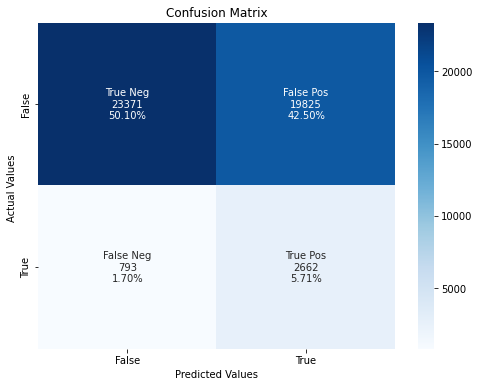

In [111]:
plot_confusion(ytest_e, y_pred)

###Feature importances

In [112]:
# Extract feature importances and calculate cumulative sum of importances
feature_importances = pd.DataFrame(grid_rf.best_estimator_.named_steps['classifier'].feature_importances_, index =names,  columns=['importance']).sort_values('importance', ascending=False)
feature_importances['cumulative_importance'] = feature_importances.importance.cumsum()

In [113]:
feature_importances

,importance,cumulative_importance
fees paid (input),0.116683,0.116683
fee as share of amount transacted (input),0.110044,0.226727
minimum amount transacted (input),0.106275,0.333002
degree (input),0.100355,0.433357
median amount transacted (input),0.093285,0.526642
total amount transacted (input),0.090526,0.617169
maximum amount transacted (input),0.089699,0.706867
mean amount transacted (input),0.084327,0.791194
fee as share of amount transacted (input)**,0.026335,0.817529
fees paid (output)**,0.024507,0.842036


In [114]:
feature_importances.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &  importance &  cumulative\\_importance \\\\\n\\midrule\nfees paid (input)                                  &    0.116683 &               0.116683 \\\\\nfee as share of amount transacted (input)          &    0.110044 &               0.226727 \\\\\nminimum amount transacted (input)                  &    0.106275 &               0.333002 \\\\\ndegree (input)                                     &    0.100355 &               0.433357 \\\\\nmedian amount transacted (input)                   &    0.093285 &               0.526642 \\\\\ntotal amount transacted (input)                    &    0.090526 &               0.617169 \\\\\nmaximum amount transacted (input)                  &    0.089699 &               0.706867 \\\\\nmean amount transacted (input)                     &    0.084327 &               0.791194 \\\\\nfee as share of amount transacted (input)**        &    0.026335 &               0.817529 \\\\\nfees paid (output)**                    

##GAT

In [115]:
epochs = 100
recall_threshold = 0.83

In [116]:
for data in train_dataset:
  data.y = torch.tensor(data.y)
  #if type(data.node[0]) == torch.Tensor:
  #    data.node = str(data.node[0].tolist())
  #elif type(data.node[0]) == str:
  #    data.node = data.node[0]

for data in test_dataset:
  data.y = torch.tensor(data.y)
#if type(data.node[0]) == torch.Tensor:
#      data.node = str(data.node[0].tolist())
#  elif type(data.node[0]) == str:
#      data.node = data.node[0]

In [117]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [118]:
def trainGAT(model):
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         data = data.to(device)
         data.y = data.y.type(torch.LongTensor).to(device)
         out, weights = model(data.x, data.edge_index, data.edge_attr, data.batch)  # Perform a single forward pass. 
         del weights
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def testGAT(model, loader):
    with torch.no_grad():
        model.eval()

            
        metrics = {"accuracy":0,
                  "precision":0,
                  "recall":0,
                  "f1_score":0,
                    "auc_score":0}

        correct = 0
        actual, predicted, node = list(), list(), list()
        attention_weights = []
        for data in loader:  # Iterate in batches over the training/test dataset.
            data = data.to(device)
            out, weights = model(data.x, data.edge_index, data.edge_attr, data.batch)  
            attention_weights += [(data.node, weights)]
            
            pred = out.cpu().argmax(dim=1).tolist()  # Use the class with highest probability.
            true = data.y.cpu().tolist()
            actual += true
            predicted += pred
            node += [data.node]

        metrics['accuracy'] = accuracy_score(actual, predicted)
        metrics['precision'], metrics['recall'], metrics['f1_score'], _ = precision_recall_fscore_support(actual, predicted, average = 'binary', zero_division=0)

    return metrics, predicted, actual, node, attention_weights  # Derive ratio of correct predictions.

def trainGATMinCut(model):
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         data = data.to(device)
         data.y = data.y.type(torch.LongTensor).to(device)
         out = model(data.x, data.edge_index, data.edge_attr, data.batch)  # Perform a single forward pass. 
         #del weights
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def testGATMinCut(model, loader):
    with torch.no_grad():
        model.eval()
            
        metrics = {"accuracy":0,
                  "precision":0,
                  "recall":0,
                  "f1_score":0,
                    "auc_score":0}

        correct = 0
        actual, predicted, node = list(), list(), list()
        attention_weights = []
        for data in loader:  # Iterate in batches over the training/test dataset.
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)  
            #attention_weights += [(data.node, weights)]
            
            pred = out.cpu().argmax(dim=1).tolist()  # Use the class with highest probability.
            true = data.y.cpu().tolist()
            actual += true
            predicted += pred
            node += [data.node]

        metrics['accuracy'] = accuracy_score(actual, predicted)
        metrics['precision'], metrics['recall'], metrics['f1_score'], _ = precision_recall_fscore_support(actual, predicted, average = 'binary', zero_division=0)

    return metrics, predicted, actual, node, attention_weights  # Derive ratio of correct predictions.

###Architecture

In [119]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, att_heads):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.gat_node_1 = GATv2Conv(24, hidden_channels, edge_dim = 4, heads = att_heads)
        self.gat_node_2 = GATv2Conv(hidden_channels * att_heads, out_channels, edge_dim = 4, heads = att_heads)

        self.lin = Linear(out_channels * att_heads, 2)

        self.pool2 = SAGPooling(att_heads * out_channels, GNN = GATConv, ratio = 0.75)

        self.graphnorm1 = GraphNorm(hidden_channels * att_heads)
        self.graphnorm2 = GraphNorm(out_channels * att_heads)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x = x.float()
        x = self.gat_node_1(x, edge_index, edge_attr = edge_attr)
        x = F.leaky_relu(x)
        x = self.graphnorm1(x)
        x, weights = self.gat_node_2(x, edge_index, edge_attr = edge_attr, return_attention_weights = True)
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.leaky_relu(x)
        x, edge_index, edge_attr, batch, perm, score = self.pool2(x, edge_index, edge_attr, batch)
        x = self.graphnorm2(x)
        
        # 2. Readout layer - turns node and edge embeddings into a graph embedding
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin(x)
        x = F.softmax(x, dim = 1)
        return x, weights


In [120]:
model = GAT(hidden_channels = 256, out_channels = 32, att_heads = 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
print(model)

GAT(
  (gat_node_1): GATv2Conv(24, 256, heads=10)
  (gat_node_2): GATv2Conv(2560, 32, heads=10)
  (lin): Linear(in_features=320, out_features=2, bias=True)
  (pool2): SAGPooling(GATConv, 320, ratio=0.75, multiplier=1.0)
  (graphnorm1): GraphNorm(2560)
  (graphnorm2): GraphNorm(320)
)


###Results

In [121]:
recall = list()
precision = list()
accuracy = list()
f1_score = list()
test_true = list()
test_pred = list()
epoch_l = list()

for epoch in range(epochs):

  trainGAT(model)
  train_metrics, train_predictions, train_actual, train_node, train_attention_weights = testGAT(model, train_loader)
  test_metrics, test_predictions, test_actual, test_node, test_attention_weights = testGAT(model, test_loader)

  recall.append(test_metrics['recall'])
  precision.append(test_metrics['precision'])
  accuracy.append(test_metrics['accuracy'])
  f1_score.append(test_metrics['f1_score'])
  test_true.append(test_actual)
  test_pred.append(test_predictions)
  epoch_l.append(epoch)
   
  print(f'Epoch: {epoch:03d} '
          f'Tr Acc: {train_metrics["accuracy"]:.3f}, Tr Rec: {train_metrics["recall"]:.3f}, Tr Pre: {train_metrics["precision"]:.3f}, Tr F1: {train_metrics["f1_score"]:.3f} '
          f'Te Acc: {test_metrics["accuracy"]:.3f}, Te Rec: {test_metrics["recall"]:.3f}, Te Pre: {test_metrics["precision"]:.3f}, Te F1: {test_metrics["f1_score"]:.3f}')


Epoch: 000 Tr Acc: 0.744, Tr Rec: 0.692, Tr Pre: 0.771, Tr F1: 0.730 Te Acc: 0.662, Te Rec: 0.743, Te Pre: 0.198, Te F1: 0.313
Epoch: 001 Tr Acc: 0.769, Tr Rec: 0.711, Tr Pre: 0.804, Tr F1: 0.755 Te Acc: 0.698, Te Rec: 0.752, Te Pre: 0.220, Te F1: 0.341
Epoch: 002 Tr Acc: 0.769, Tr Rec: 0.718, Tr Pre: 0.800, Tr F1: 0.757 Te Acc: 0.701, Te Rec: 0.739, Te Pre: 0.220, Te F1: 0.339
Epoch: 003 Tr Acc: 0.775, Tr Rec: 0.736, Tr Pre: 0.799, Tr F1: 0.766 Te Acc: 0.688, Te Rec: 0.758, Te Pre: 0.215, Te F1: 0.335
Epoch: 004 Tr Acc: 0.787, Tr Rec: 0.748, Tr Pre: 0.811, Tr F1: 0.778 Te Acc: 0.708, Te Rec: 0.770, Te Pre: 0.229, Te F1: 0.353
Epoch: 005 Tr Acc: 0.793, Tr Rec: 0.750, Tr Pre: 0.820, Tr F1: 0.783 Te Acc: 0.721, Te Rec: 0.775, Te Pre: 0.239, Te F1: 0.365
Epoch: 006 Tr Acc: 0.793, Tr Rec: 0.771, Tr Pre: 0.806, Tr F1: 0.788 Te Acc: 0.709, Te Rec: 0.785, Te Pre: 0.232, Te F1: 0.358
Epoch: 007 Tr Acc: 0.797, Tr Rec: 0.793, Tr Pre: 0.800, Tr F1: 0.796 Te Acc: 0.699, Te Rec: 0.788, Te Pre: 0.22

In [123]:
gat_epochs = pd.DataFrame({'epoch':epoch_l, 'recall':recall, 'precision':precision, 'accuracy':accuracy, 'f1':f1_score,'pred':test_pred})
max = gat_epochs.loc[gat_epochs[gat_epochs.recall>recall_threshold]['f1'].idxmax()]
max_accuracy = max['accuracy']
max_precision = max['precision']
max_recall = max['recall']
max_f1 = max['f1']

In [124]:
results = results.append({'model':'GAT','auc':0,'acc':max_accuracy,'pre':max_precision,'rec':max_recall,'f1':max_f1}, ignore_index=True)

##GAT + MinCut

In [125]:
# calculate average nodes
average_nodes = 0
total_data = 0
for data in train_loader:
    total_data += 1
    average_nodes = average_nodes + data.num_nodes

average_nodes = average_nodes / total_data

###Architecture

In [126]:
class GATMinCut(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, att_heads):
        super(GATMinCut, self).__init__()
        torch.manual_seed(12345)
        
        self.gat_node_1 = GATv2Conv(24, hidden_channels, edge_dim = 4, heads = att_heads)
        self.mincut1 = MinCut(in_channels = hidden_channels * att_heads, hidden_channels = hidden_channels, out_channels = out_channels)
        self.graphnorm1 = GraphNorm(out_channels)
        
        self.lin = Linear(out_channels, 2)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x = x.float()

        x = self.gat_node_1(x, edge_index, edge_attr = edge_attr)
        x = F.leaky_relu(x)
        x = self.mincut1(x, edge_index, batch)
        x = self.graphnorm1(x)
        
        # 3. Apply a final classifier
        x = self.lin(x)
        x = F.softmax(x, dim = -1)
        
        return x

class MinCut(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=32):
        super().__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        num_nodes = math.ceil(0.5 * average_nodes)
        self.pool1 = Linear(hidden_channels, num_nodes)

        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        num_nodes = math.ceil(0.5 * num_nodes)
        self.pool2 = Linear(hidden_channels, num_nodes)

        self.conv3 = DenseGraphConv(hidden_channels, hidden_channels)

        self.lin1 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()

        x, mask = to_dense_batch(x, batch)
        adj = to_dense_adj(edge_index, batch)

        s = self.pool1(x)
        x, adj, mc1, o1 = dense_mincut_pool(x, adj, s, mask)

        x = self.conv2(x, adj).relu()
        s = self.pool2(x)

        x, adj, mc2, o2 = dense_mincut_pool(x, adj, s)

        x = self.conv3(x, adj)

        x = x.mean(dim=1)
        x = self.lin1(x).relu()
        return x

In [127]:
# model
model = GATMinCut(hidden_channels = 128, out_channels = 32, att_heads = 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
print(model)

GATMinCut(
  (gat_node_1): GATv2Conv(24, 128, heads=10)
  (mincut1): MinCut(
    (conv1): GCNConv(1280, 128)
    (pool1): Linear(in_features=128, out_features=1031, bias=True)
    (conv2): DenseGraphConv(128, 128)
    (pool2): Linear(in_features=128, out_features=516, bias=True)
    (conv3): DenseGraphConv(128, 128)
    (lin1): Linear(in_features=128, out_features=32, bias=True)
  )
  (graphnorm1): GraphNorm(32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)


###Results

In [128]:
recall_mc = list()
precision_mc = list()
accuracy_mc = list()
f1_score_mc = list()
test_true_mc = list()
test_pred_mc = list()
epoch_mc = list()

for epoch in range(epochs):
  trainGATMinCut(model)
  train_metrics_mc, train_predictions_mc, train_actual_mc, train_node_mc, train_attention_weights_mc = testGATMinCut(model, train_loader)
  test_metrics_mc, test_predictions_mc, test_actual_mc, test_node_mc, test_attention_weights_mc = testGATMinCut(model, test_loader)

  recall_mc.append(test_metrics_mc['recall'])
  precision_mc.append(test_metrics_mc['precision'])
  accuracy_mc.append(test_metrics_mc['accuracy'])
  f1_score_mc.append(test_metrics_mc['f1_score'])
  test_true_mc.append(test_actual_mc)
  test_pred_mc.append(test_predictions_mc)
  epoch_mc.append(epoch)

  print(f'Epoch: {epoch:03d} '
          f'Tr Acc: {train_metrics_mc["accuracy"]:.3f}, Tr Rec: {train_metrics_mc["recall"]:.3f}, Tr Pre: {train_metrics_mc["precision"]:.3f}, Tr F1: {train_metrics_mc["f1_score"]:.3f} '
          f'Te Acc: {test_metrics_mc["accuracy"]:.3f}, Te Rec: {test_metrics_mc["recall"]:.3f}, Te Pre: {test_metrics_mc["precision"]:.3f}, Te F1: {test_metrics_mc["f1_score"]:.3f}')

Epoch: 000 Tr Acc: 0.743, Tr Rec: 0.778, Tr Pre: 0.727, Tr F1: 0.752 Te Acc: 0.548, Te Rec: 0.870, Te Pre: 0.171, Te F1: 0.285
Epoch: 001 Tr Acc: 0.766, Tr Rec: 0.764, Tr Pre: 0.767, Tr F1: 0.766 Te Acc: 0.673, Te Rec: 0.800, Te Pre: 0.213, Te F1: 0.337
Epoch: 002 Tr Acc: 0.761, Tr Rec: 0.767, Tr Pre: 0.759, Tr F1: 0.763 Te Acc: 0.646, Te Rec: 0.797, Te Pre: 0.199, Te F1: 0.318
Epoch: 003 Tr Acc: 0.778, Tr Rec: 0.776, Tr Pre: 0.779, Tr F1: 0.778 Te Acc: 0.702, Te Rec: 0.792, Te Pre: 0.229, Te F1: 0.355
Epoch: 004 Tr Acc: 0.787, Tr Rec: 0.783, Tr Pre: 0.788, Tr F1: 0.786 Te Acc: 0.702, Te Rec: 0.796, Te Pre: 0.229, Te F1: 0.356
Epoch: 005 Tr Acc: 0.791, Tr Rec: 0.787, Tr Pre: 0.794, Tr F1: 0.790 Te Acc: 0.716, Te Rec: 0.803, Te Pre: 0.240, Te F1: 0.369
Epoch: 006 Tr Acc: 0.795, Tr Rec: 0.770, Tr Pre: 0.811, Tr F1: 0.790 Te Acc: 0.736, Te Rec: 0.787, Te Pre: 0.252, Te F1: 0.382
Epoch: 007 Tr Acc: 0.779, Tr Rec: 0.780, Tr Pre: 0.779, Tr F1: 0.779 Te Acc: 0.688, Te Rec: 0.784, Te Pre: 0.21

In [129]:
gatmc_epochs = pd.DataFrame({'epoch':epoch_mc, 'recall':recall_mc, 'precision':precision_mc, 'accuracy':accuracy_mc, 'f1':f1_score_mc,'pred':test_pred_mc})
max_mc = gatmc_epochs.loc[gatmc_epochs[gatmc_epochs.recall>recall_threshold]['f1'].idxmax()]
max_accuracy_mc = max_mc['accuracy']
max_precision_mc = max_mc['precision']
max_recall_mc = max_mc['recall']
max_f1_mc = max_mc['f1']

In [130]:
results = results.append({'model':'GAT + MinCut','auc':0,'acc':max_accuracy_mc,'pre':max_precision_mc,'rec':max_recall_mc,'f1':max_f1_mc}, ignore_index=True)

In [131]:
results[['model','rec','pre','f1','acc']]

,model,rec,pre,f1,acc
0,logit nodes,0.437441,0.174118,0.249089,0.727406
1,logit edges,0.956295,0.081415,0.150056,0.197681
2,rf nodes,0.789573,0.277112,0.410244,0.765369
3,rf nodes,0.789573,0.277112,0.410244,0.765369
4,rf edges,0.770478,0.118380,0.205227,0.558037
5,GAT,0.831758,0.262843,0.399455,0.740766
6,GAT + MinCut,0.832703,0.258509,0.394536,0.735084


In [135]:
results[['model','rec','pre','f1','acc']].to_latex(index=False)

'\\begin{tabular}{lrrrr}\n\\toprule\n       model &      rec &      pre &       f1 &      acc \\\\\n\\midrule\n logit nodes & 0.437441 & 0.174118 & 0.249089 & 0.727406 \\\\\n logit edges & 0.956295 & 0.081415 & 0.150056 & 0.197681 \\\\\n    rf nodes & 0.789573 & 0.277112 & 0.410244 & 0.765369 \\\\\n    rf nodes & 0.789573 & 0.277112 & 0.410244 & 0.765369 \\\\\n    rf edges & 0.770478 & 0.118380 & 0.205227 & 0.558037 \\\\\n         GAT & 0.831758 & 0.262843 & 0.399455 & 0.740766 \\\\\nGAT + MinCut & 0.832703 & 0.258509 & 0.394536 & 0.735084 \\\\\n\\bottomrule\n\\end{tabular}\n'

##Extra

In [132]:
train_node = [item for sublist in train_node for item in sublist]
train_pred = pd.DataFrame(index = train_node)
train_pred['actual'] = train_actual
train_pred['pred'] = train_predictions
train_pred.to_csv('/content/drive/MyDrive/Augmented_Elliptic/address_level/GAT_train_pred.csv')

In [133]:
test_node = [item for sublist in test_node for item in sublist]
test_pred = pd.DataFrame(index = test_node)
test_pred['actual'] = test_actual
test_pred['pred'] = test_predictions
test_pred.to_csv('/content/drive/MyDrive/Augmented_Elliptic/address_level/GAT_test_pred.csv')

In [134]:
print(len(train_pred))
print(len(test_pred))

18876
10207
